<a href="https://colab.research.google.com/github/SebasIn-13/time_series_multivariate_classification/blob/main/Proyecto_Aprendizaje_Profundo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd ../home/sinsuasti/Proyecto_Aprendizaje_Profundo/

/home/sinsuasti/Proyecto_Aprendizaje_Profundo


# Comparación de Modelos Secuenciales PyTorch Lightning
## Objetivos

- Definir un modelo recurrente para clasificacion de origen de nombres
- Basada en https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

## Instalar e importar bibliotecas


In [2]:
import os
from io import open
import unicodedata
import string
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
import torchmetrics
from sklearn.model_selection import train_test_split
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import TQDMProgressBar, RichProgressBar, EarlyStopping
from torch.nn.utils.rnn import pad_sequence # Se añade esta librería por diferencias en tamaño de palabras en el batch
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import timeit
import time

In [4]:
# !pip install liac-arff

In [5]:
import arff
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def load_arff_channel(path):
    with open(path) as f:
        dataset = arff.load(f)
    df = pd.DataFrame(dataset['data'], columns=[attr[0] for attr in dataset['attributes']])
    arr = df.to_numpy()
    X_channel = arr[:, :-1]   # all but last column → timesteps
    y = arr[:, -1]            # last column → class

    # Convert to integers
    le = LabelEncoder()
    y = le.fit_transform(y)
    y = [int(v) for v in y]
    y=np.array(y)

    return X_channel, y

### Preparación de Datos

Se mezcla las muestras de entrenamiento y prueba del DataSet para incrementar los datos de entrenamiento y utilizar una proporción de 20% test con las clases estratificadas.

In [6]:
# Se carga todos los canales tanto de Test como de Train
files = [f"ArticularyWordRecognitionDimension{i}_TRAIN.arff" for i in range(1, 10)]

channels = []
labels = None
for f in files:
    X_channel, y = load_arff_channel(f)
    channels.append(X_channel)
    if labels is None:   # take class labels from first channel only
        labels = y

X_train = np.stack(channels, axis=-1)
y_train = labels

print("X_train shape:", X_train.shape)  # (275, 144, 9)
print("y_train shape:", y_train.shape)  # (275,)

X_train shape: (275, 144, 9)
y_train shape: (275,)


In [7]:
# === Load all channels in TEST ===
files = [f"ArticularyWordRecognitionDimension{i}_TEST.arff" for i in range(1, 10)]

channels = []
labels = None
for f in files:
    X_channel, y = load_arff_channel(f)
    channels.append(X_channel)
    if labels is None:   # take class labels from first channel only
        labels = y

X_test = np.stack(channels, axis=-1)
y_test = labels

print("X_test shape:", X_test.shape)  # (275, 144, 9)
print("y_test shape:", y_test.shape)  # (275,)

X_test shape: (300, 144, 9)
y_test shape: (300,)


In [8]:
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train,y_test), axis=0)
all_categories=[int(element) for element in set(y)]
all_categories.sort()
print("X shape:", X.shape)  # (575, 144, 9)
print("y shape:",y.shape)
print("Categorías:",all_categories)

X shape: (575, 144, 9)
y shape: (575,)
Categorías: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


## HIPERPARÁMETROS

**NUM_EPOCHS**: Se selecciona un valor grande de número de épocas ya que modelos como LSTM tienen un entrenamiento más lento con el mismo Learning Rate, por lo que se coloca un valor máximo grande para que el entrenamiento se detenga debido a la PACIENCIA.

**PATIENCE**: Se coloca una paciencia de 20 ya que durante el entrenamiento hay unas cuantas oscilaciones que pueden indicar que el entrenamiento ya no está mejorando el desempeño, pero es muy fluctuante, por lo que se coloca un valor del 10% del número de épocas como una cantidad significativa de épocas sin mejora antes de detener el entrenamiento.

**BATCH_SIZE**: Se eligió un batch_size estandard de 16.

**LEARNING_RATE**: Se definió este valor de 1e-4 buscando el mejor desempeño únicamente con el modelo RNN, por lo que una resintonización para cada modelo puede mejorar los resultados.

**HIDDEN_DIM**: Se eligió un total de 158 dimensiones para las dimensiones ocultas dentro de los distintos modelos de RNN lo que permite tener una gran cantidad de parámetros sintonizables. Se colocó este valor ya que permite una sintonización más fina, sin alcanzar de forma perceptible en las curvas de entrenamiento el overfitting del modelo.

**NUM_LAYERS**: Para buscar un mejor desempeño, se decidió hacer la red neuronal más profunda, colocando 6 capas de cada modelo, en lugar de únicamente una. Este cambio incrementa considerablemente la cantidad de parámetros a entrenar pero permite mejorar el F1Score.

**NUM_WORKERS**: Se define el número de workers como 4 para tener entrenamientos más cortos utilizando los recursos del servidor adecuadamente para permitir que los otros grupos y personas conectadas al mismo realicen sus entrenamientos sin saturar el uso de GPU.

**OTROS CAMBIOS**

**F1_SCORE**: Se decide utilizar esta métrica para esta tarea de clasificación que se considera igual de apropiada que el accuracy. Se la implementa como "macro F1-Score" para que se les atribuya el mismo peso a todas las clases independientemente de cuántas muestras contengan, aunque en este caso el cambio entre macro y micro sea insignificante debido al balance de las mismas.

**CLASS_WEIGHTS**: Se utiliza un código que tiene implementado class_weights para compensar desbalances, pero en este caso todos los pesos son iguales a 1, por lo que se mantiene esta convención.

In [9]:
NUM_EPOCHS=200
PATIENCE=20
BATCH_SIZE=16
LEARNING_RATE=1e-4
HIDDEN_DIM=158
NUM_LAYERS=6
NUM_WORKERS=4

## Preparación de datos
### Importamos archivos de texto de nombres

### Extraer todas las letras

In [10]:
label_names={0:'Word 0',
             1:'Word 1',
             2:'Word 2',
             3:'Word 3',
             4:'Word 4',
             5:'Word 5',
             6:'Word 6',
             7:'Word 7',
             8:'Word 8',
             9: 'Word 9',
             10:'Word 10',
             11:'Word 11',
             12:'Word 12',
             13:'Word 13',
             14:'Word 14',
             15:'Word 15',
             16:'Word 16',
             17:'Word 17',
             18:'Word 18',
             19:'Word 19',
             20:'Word 20',
             21:'Word 21',
             22:'Word 22',
             23:'Word 23',
             24:'Word 24'}

### Class Balance

In [11]:
# Se analiza la distribución de los datos y se calcula los pesos por clase para el cómputo del loss
from collections import Counter
import numpy as np

n_dimensions= X.shape[2]
counts = Counter(y)  # Se realiza un conteo de los labels
n_categories = len(all_categories)

# Se convierte las categorías en sus respectivos índices en un diccionario
category_to_idx = {category: i for i, category in enumerate(all_categories)}

# Se convierte los conteos en un arreglo por índice
class_counts = np.array([counts.get(cat, 1) for cat in all_categories])  #Se utiliza get para asegurar que exista,

# Se invierte el conteo para obtener la frecuencia
class_freqs = 1.0 / class_counts

# El peso se obtiene normalizando el peso entre categorías
class_weights = class_freqs / class_freqs.sum() * n_categories

class_weights = torch.tensor(class_weights, dtype=torch.float)

print(class_weights)

# print("Se corrigen los pesos para que no haya valores menores a 1 (perjudica el entrenamiento)")
# class_weights = torch.clamp(class_weights, min=1)

# # print(class_weights)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1.])


[23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23
 23]


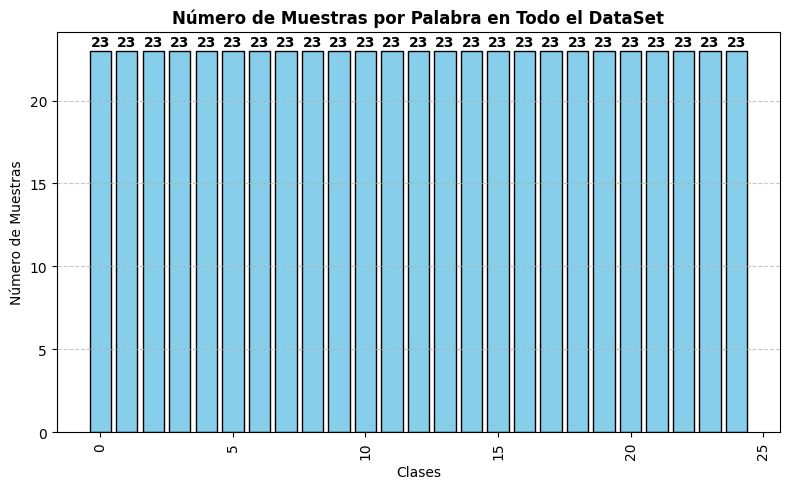

In [12]:
# PLOT DE DISTRIBUCIÓN DE PIXELES EN DATALOADER TRAIN
import matplotlib.pyplot as plt

# Crear el histograma
plt.figure(figsize=(8, 5))
bars = plt.bar(all_categories, class_counts, color='skyblue', edgecolor='black')
print(class_counts)
# Añadir etiquetas y título
plt.xlabel('Clases')
plt.ylabel('Número de Muestras')
plt.title('Número de Muestras por Palabra en Todo el DataSet', fontweight='bold')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir valores arriba de cada barra
for bar, freq in zip(bars, class_counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height * 1.005,  # Posición dentro de la barra
             f'{freq:.0f}', ha='center', va='bottom', fontsize=10, color='k', fontweight='bold')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

### Transformación a Tensores dentro de un DataSet

In [13]:
import torch
from torch.utils.data import Dataset, DataLoader

def collate_fn(batch):
    names, labels, lengths = zip(*batch)

    # Realiza padding en función de la dimensión más grande
    names_padded = pad_sequence(names, batch_first=True)

    # Convierte los labels a tensores
    labels = torch.tensor(labels, dtype=torch.long)
    lengths = torch.tensor(lengths, dtype=torch.long)

    return names_padded, labels, lengths

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.tensor(X, dtype=torch.float32)  # (N, T, D)
        self.y = torch.tensor(y, dtype=torch.long) if y is not None else None

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            length = self.X[idx].size(0)
            return self.X[idx], self.y[idx], length

        return self.X[idx]

### DataLoader para Pytorch Lightning

In [14]:
class MyDataModule(pl.LightningDataModule):
    def __init__(self, X, y, batch_size=32, test_size=0.2, val_size=0.1, seed=42, num_workers=1, collate_fn=collate_fn):
        super().__init__()
        self.X = np.array(X, dtype=np.float32)
        self.y = y
        self.batch_size = batch_size
        self.test_size = test_size
        self.val_size = val_size
        self.seed = seed
        self.num_workers= num_workers
        self.collate_fn=collate_fn

    def setup(self, stage=None):
        # Se divide en entrenamiento-validación y test
        X_trainval, X_test, y_trainval, y_test = train_test_split(
            self.X, self.y,
            test_size=self.test_size,   # proportion reserved for final test
            random_state=self.seed,
            stratify=self.y
        )

        # Se divide entrenamiento-validación en entrenamiento y validación
        X_train, X_val, y_train, y_val = train_test_split(
            X_trainval, y_trainval,
            test_size=self.val_size,
            random_state=self.seed,
            stratify=y_trainval
        )

        self.train_dataset = TimeSeriesDataset(X_train, y_train)
        self.val_dataset   = TimeSeriesDataset(X_val, y_val)
        self.test_dataset  = TimeSeriesDataset(X_test, y_test)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers, collate_fn=self.collate_fn)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers, collate_fn=self.collate_fn)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=self.num_workers, collate_fn=self.collate_fn)

In [15]:
# Inicializamos el DataModule Lightning con batch_size=1 debido a que tienen distintas dimensiones y hay conflictos en el batch
data_module = MyDataModule(X, y, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

# Se imprime el batch para observar que esté funcionando adecuadamente con las transformaciones para tener una mejor retroalimentación
data_module.setup()

print("Evaluación DataLoader")
for inputs, classes, _ in data_module.train_dataloader():
    # for name_tensor, label in zip(inputs, classes):
    #     word = label_names[label.item()]
    #     print("Shape de Muestra", name_tensor.shape,"| Label:", label, "| Category:", word)

    print("Batch dimension:", inputs.shape)
    # break

Evaluación DataLoader
Batch dimension: torch.Size([16, 144, 9])
Batch dimension: torch.Size([16, 144, 9])
Batch dimension: torch.Size([16, 144, 9])
Batch dimension: torch.Size([16, 144, 9])
Batch dimension: torch.Size([16, 144, 9])
Batch dimension: torch.Size([16, 144, 9])
Batch dimension: torch.Size([16, 144, 9])
Batch dimension: torch.Size([16, 144, 9])
Batch dimension: torch.Size([16, 144, 9])
Batch dimension: torch.Size([16, 144, 9])
Batch dimension: torch.Size([16, 144, 9])
Batch dimension: torch.Size([16, 144, 9])
Batch dimension: torch.Size([16, 144, 9])
Batch dimension: torch.Size([16, 144, 9])
Batch dimension: torch.Size([16, 144, 9])
Batch dimension: torch.Size([16, 144, 9])
Batch dimension: torch.Size([16, 144, 9])
Batch dimension: torch.Size([16, 144, 9])
Batch dimension: torch.Size([16, 144, 9])
Batch dimension: torch.Size([16, 144, 9])
Batch dimension: torch.Size([16, 144, 9])
Batch dimension: torch.Size([16, 144, 9])
Batch dimension: torch.Size([16, 144, 9])
Batch dimens

### Preprocesamiento para Modelos Convencionales

In [16]:
def dataloader_to_numpy(dataloader):
    X_list, y_list = [], []

    for inputs, classes, *_ in dataloader:
        # inputs: (batch, T, D)
        X_list.append(inputs.numpy())
        y_list.append(classes.numpy())

    X_np = np.concatenate(X_list, axis=0)  # (N, T, D)
    y_np = np.concatenate(y_list, axis=0)  # (N,)

    return X_np, y_np

In [17]:
X_train, y_train = dataloader_to_numpy(data_module.train_dataloader())
X_val, y_val = dataloader_to_numpy(data_module.val_dataloader())
X_test, y_test   = dataloader_to_numpy(data_module.test_dataloader())

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)

Train shape: (414, 144, 9)
Validation shape: (46, 144, 9)
Test shape: (115, 144, 9)


In [18]:
X_train_val = np.concatenate([X_train, X_val], axis=0)
y_train_val = np.concatenate([y_train, y_val], axis=0)

X_full = np.concatenate([X_train_val, X_test], axis=0)
y_full = np.concatenate([y_train_val, y_test], axis=0)

print("Full shape:", X_full.shape)

Full shape: (575, 144, 9)


## MODELOS CONVENCIONALES

### Modelo Estadístico y SVM

In [19]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

def extract_features(X):
    n_samples, n_timesteps, n_channels = X.shape
    features = []

    for i in range(n_samples):
        sample_feats = {}
        for d in range(n_channels):
            signal = X[i, :, d].astype(float)
            # Basic stats
            sample_feats[f"mean_dim{d}"] = np.mean(signal)
            sample_feats[f"std_dim{d}"] = np.std(signal)
            sample_feats[f"min_dim{d}"] = np.min(signal)
            sample_feats[f"max_dim{d}"] = np.max(signal)
            # Shape stats
            sample_feats[f"skew_dim{d}"] = skew(signal)
            sample_feats[f"kurt_dim{d}"] = kurtosis(signal)
            # Percentiles
            sample_feats[f"p25_dim{d}"] = np.percentile(signal, 25)
            sample_feats[f"p50_dim{d}"] = np.percentile(signal, 50)
            sample_feats[f"p75_dim{d}"] = np.percentile(signal, 75)
            # Energy
            sample_feats[f"energy_dim{d}"] = np.sum(signal**2) / n_timesteps
        features.append(sample_feats)

    return pd.DataFrame(features)

inicio = time.time()
X_train_1=extract_features(X_train_val)
fin = time.time()
print("Tiempo promedio feature extraction Estadístico:", (fin-inicio), "segundos")
y_train_1=y_train_val

X_test_1=extract_features(X_test)
y_test_1=y_test

X_full_1=extract_features(X_full)
y_full_1=y_full

print("Modelo Estadístico")
print("Train shape:", X_train_1.shape)
print("Test shape:", X_test_1.shape)

Tiempo promedio feature extraction Estadístico: 2.4609851837158203 segundos
Modelo Estadístico
Train shape: (460, 90)
Test shape: (115, 90)


<ipython-input-20-204fd39afcc0>:30: UserWarning: The palette list has more values (27) than needed (25), which may not be intended.
  sns.scatterplot(data=principal_df, x='tSNE1', y='tSNE2', hue=principal_df['LABEL'], palette=palette, s=50, alpha=1)


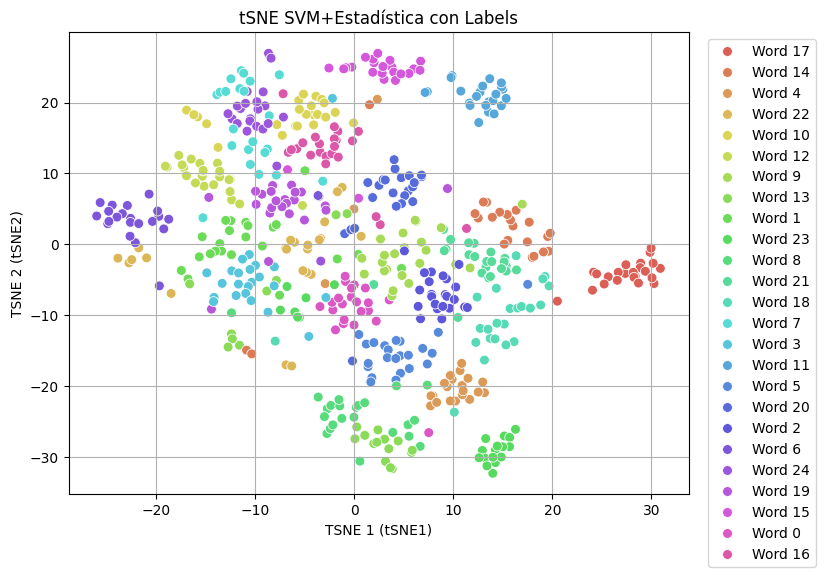

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler # Transformar los datos a promedio 0 y dev std 1

random_state=42
n_componentes=2

# Estandarizar los datos
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X_full_1)

# TSNE
tsne = TSNE(n_components=n_componentes,random_state=random_state)
embeddings = tsne.fit_transform(scaled_X)

# Crear un dataframe para las componentes principales
columns = [f'tSNE{i+1}' for i in range(n_componentes)]
principal_df = pd.DataFrame(data=embeddings, columns=columns)
labels = y_full # Añadir la columna de etiquetas (no usada para PCA)

principal_df['LABEL'] = [label_names[label] for label in labels]

# Graficar los puntos en 2D y la matriz rotacion
palette = sns.color_palette("hls", len(label_names)+2)  # or "gist_ncar", "nipy_spectral", etc.
if n_componentes == 2:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=principal_df, x='tSNE1', y='tSNE2', hue=principal_df['LABEL'], palette=palette, s=50, alpha=1)

    plt.title('tSNE SVM+Estadística con Labels')
    plt.xlabel("TSNE 1 (tSNE1)")
    plt.ylabel("TSNE 2 (tSNE2)")
    plt.legend(bbox_to_anchor=(1.02, 1))
    plt.grid()
    plt.show()

In [21]:
from sklearn.model_selection import RepeatedStratifiedKFold #StratifiedKFold para cross-validation
kfold = RepeatedStratifiedKFold(n_splits=4, n_repeats=1, random_state=random_state)

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Definimos los rangos para C y para Gamma
C_range = np.logspace(-2,4,num=4)
Gamma_range = np.logspace(-2, 4, num=4)

# pipeline
pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf'))
])

search_space = {
    'svm__C': Real(1e-1, 1e+6, prior='log-uniform'),
    'svm__gamma': Real(1e-4, 1e+4, prior='log-uniform')
}

search_svm = BayesSearchCV(estimator=pipeline_svm,
                      search_spaces=search_space, scoring='f1_macro',
                      cv=kfold,
                      verbose=4,
                      return_train_score=True,
                      n_jobs=-1) #use all available CPUs
inicio = time.time()
result_svm = search_svm.fit(X_train_1, y_train_1)
fin = time.time()

print("Tiempo optimización SVM+Estadística:", (fin-inicio), "segundos")

print(f'SVM mejor Macro F1 Score en el conj. de validación: {result_svm.best_score_} para {result_svm.best_params_}')

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fi

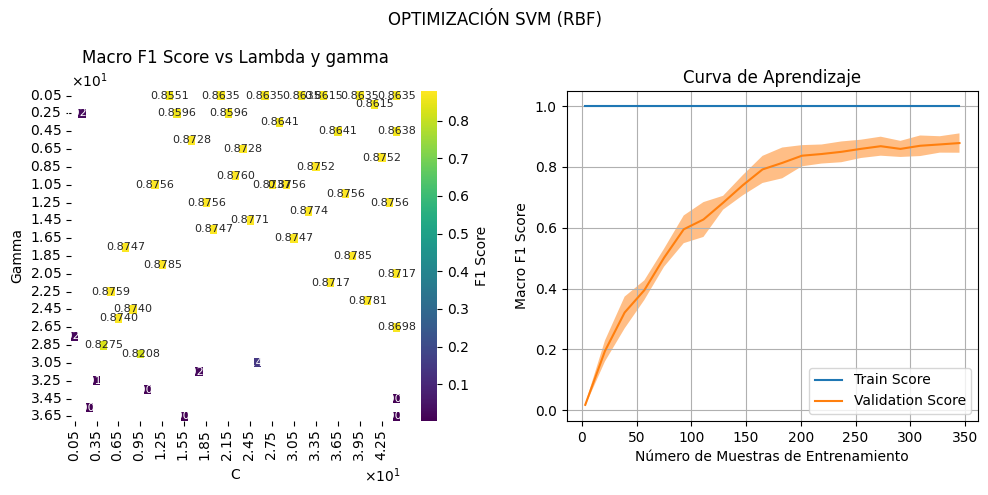

In [22]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import LearningCurveDisplay

# Crea el subplot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
results_svm = search_svm.cv_results_

# Obtener los resultados del search
C_values= results_svm['param_svm__C'].data
Gamma_values= results_svm['param_svm__gamma'].data
mean_test_scores = results_svm['mean_test_score']

# Crear un DataFrame con los resultados
results_df = pd.DataFrame({
    'C': [(C_value) for C_value in C_values], #Se convierte C en Lambda
    'Gamma': [gamma for gamma in Gamma_values], #2 cifras decimales
    'mean_test_score': mean_test_scores
})

# Redondear Lambda y Gamma a 2 decimales para mejorar presentación
results_df['C'] = results_df['C'].round(4)
results_df['Gamma'] = results_df['Gamma'].round(4)

# print(results_df)
# dupes = results_df[results_df.duplicated(subset=["Gamma", "C"], keep=False)]
# print(dupes.sort_values(["Gamma","C"]))

# Pivotar el DataFrame para crear una tabla de resultados
results_df = results_df.pivot(index='Gamma', columns='C', values='mean_test_score')

# Crear el heatmap
sns.heatmap(results_df, annot=True, cmap="viridis", cbar_kws={'label': 'F1 Score'}, annot_kws={"size": 8}, ax=axs[0],fmt=".4f")
axs[0].set_xlabel('C')
axs[0].set_ylabel('Gamma')
axs[0].set_title('Macro F1 Score vs Lambda y gamma')

# Se aplica notación científica en los ejes
axs[0].xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
axs[0].xaxis.get_major_formatter().set_scientific(True)
axs[0].xaxis.get_major_formatter().set_powerlimits((-1, 1))

axs[0].yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
axs[0].yaxis.get_major_formatter().set_scientific(True)
axs[0].yaxis.get_major_formatter().set_powerlimits((-1, 1))

train_sizes=np.linspace(0.01,1.0,20) # Desde el 1% del train (106 muestras) al 100% (10635), en total 30 valores

# Graficar la curva de Aprendizaje
pipeline_svm.set_params(svm__C=result_svm.best_params_['svm__C'],
                        svm__gamma=result_svm.best_params_['svm__gamma'],
                        svm__probability=True)

LearningCurveDisplay.from_estimator(pipeline_svm, X=X_train_1,y=y_train_1,
                                    train_sizes=train_sizes, cv=kfold,
                                    scoring='f1_macro', ax=axs[1], n_jobs=-1)

axs[1].set_title('Curva de Aprendizaje')
axs[1].legend(['Train Score', 'Validation Score'])
axs[1].set_xlabel('Número de Muestras de Entrenamiento')
axs[1].set_ylabel('Macro F1 Score')
axs[1].grid(True)
plt.suptitle("OPTIMIZACIÓN SVM (RBF)")
plt.tight_layout()
plt.show()

Tiempo de inferencia SVM+Estadística: 0.6384587287902832 segundos

Resultados SVM en Test:
acc = 0.9565, macro_f1 = 0.9550, macro_recall = 0.9560, macro_precision = 0.9686


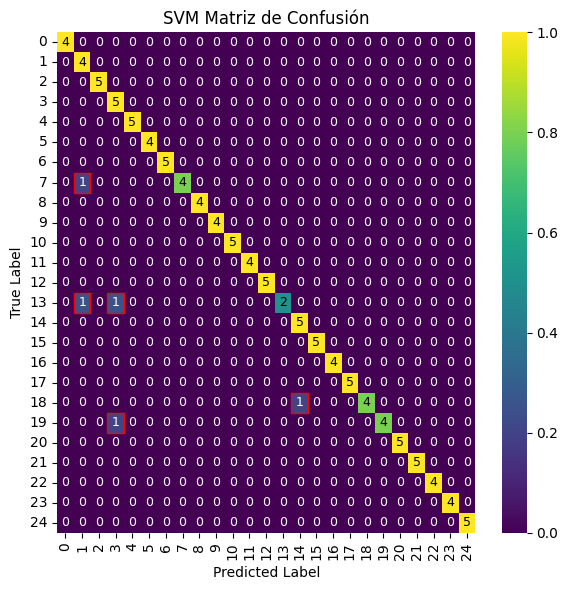

Errores de clasificación: 5/115


In [23]:
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# EVALUACIÓN EN TEST
#reentreno con mejores
pipeline_svm.set_params(svm__C=result_svm.best_params_['svm__C'],
                        svm__gamma=result_svm.best_params_['svm__gamma'],
                        svm__probability=True)
pipeline_svm.fit(X_train_1, y_train_1)

# Evaluamos en el conjunto de test
# Preprocesamiento de datos para el modelo SVM+tsfresh
inicio=time.time()
X_test_1=extract_features(X_test)
pred_test_svm = pipeline_svm.predict(X_test_1)
fin=time.time()
print("Tiempo de inferencia SVM+Estadística:", (fin-inicio), "segundos")


pred_test_svm = pipeline_svm.predict(X_test_1)

macro_f1 = metrics.f1_score(y_test, pred_test_svm, average='macro')
acc = metrics.accuracy_score(y_test, pred_test_svm)
macro_recall = metrics.recall_score(y_test, pred_test_svm, average='macro')
macro_precision = metrics.precision_score(y_test, pred_test_svm, average='macro')

print(f"\nResultados SVM en Test:")
print(f"acc = {acc:.4f}, macro_f1 = {macro_f1:.4f}, macro_recall = {macro_recall:.4f}, macro_precision = {macro_precision:.4f}")

cm = confusion_matrix(y_test, pred_test_svm)
cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]
cm_normalized = np.nan_to_num(cm_normalized)  # replace NaN with 0

fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm_normalized, xticklabels=all_categories, yticklabels=all_categories,
    cmap="viridis", cbar=True, annot=False,ax=ax)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title(f"SVM Matriz de Confusión")
# Annotate with counts
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        text_color = "white" if cm_normalized[i, j] < 0.5 else "black"
        ax.text(j + 0.5, i + 0.5, str(count),
                ha="center", va="center", color=text_color, fontsize=9)

# Highlight errors with red rectangles
errores = 0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if i != j and cm[i, j] > 0:
            ax.add_patch(
                plt.Rectangle((j, i), 1, 1,
                              fill=False, edgecolor='red', linewidth=1)
            )
            errores += cm[i, j]

plt.tight_layout()
plt.show()
print(f"Errores de clasificación: {errores}/{len(y_test)}")

In [24]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

def extract_features(X):
    n_samples, n_timesteps, n_channels = X.shape
    features = []

    for i in range(n_samples):
        sample_feats = {}
        for d in range(n_channels):
            signal = X[i, :, d].astype(float)
            # Basic stats
            sample_feats[f"mean_dim{d}"] = np.mean(signal)
            sample_feats[f"std_dim{d}"] = np.std(signal)
            sample_feats[f"min_dim{d}"] = np.min(signal)
            sample_feats[f"max_dim{d}"] = np.max(signal)
            # Shape stats
            sample_feats[f"skew_dim{d}"] = skew(signal)
            sample_feats[f"kurt_dim{d}"] = kurtosis(signal)
            # Percentiles
            sample_feats[f"p25_dim{d}"] = np.percentile(signal, 25)
            sample_feats[f"p50_dim{d}"] = np.percentile(signal, 50)
            sample_feats[f"p75_dim{d}"] = np.percentile(signal, 75)
            # Energy
            sample_feats[f"energy_dim{d}"] = np.sum(signal**2) / n_timesteps
        features.append(sample_feats)

    return pd.DataFrame(features)

inicio = time.time()
X_train_1=extract_features(X_train_val)
fin = time.time()
print("Tiempo promedio feature extraction Estadístico:", (fin-inicio), "segundos")
y_train_1=y_train_val

X_test_1=extract_features(X_test)
y_test_1=y_test

X_full_1=extract_features(X_full)
y_full_1=y_full

print("Modelo Estadístico")
print("Train shape:", X_train_1.shape)
print("Test shape:", X_test_1.shape)

Tiempo promedio feature extraction Estadístico: 2.518677234649658 segundos
Modelo Estadístico
Train shape: (460, 90)
Test shape: (115, 90)


In [25]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

def extract_features(X):
    n_samples, n_timesteps, n_channels = X.shape
    features = []

    for i in range(n_samples):
        sample_feats = {}
        for d in range(n_channels):
            signal = X[i, :, d].astype(float)
            # Basic stats
            sample_feats[f"mean_dim{d}"] = np.mean(signal)
            sample_feats[f"std_dim{d}"] = np.std(signal)
            sample_feats[f"min_dim{d}"] = np.min(signal)
            sample_feats[f"max_dim{d}"] = np.max(signal)
            # Shape stats
            sample_feats[f"skew_dim{d}"] = skew(signal)
            sample_feats[f"kurt_dim{d}"] = kurtosis(signal)
            # Percentiles
            sample_feats[f"p25_dim{d}"] = np.percentile(signal, 25)
            sample_feats[f"p50_dim{d}"] = np.percentile(signal, 50)
            sample_feats[f"p75_dim{d}"] = np.percentile(signal, 75)
            # Energy
            sample_feats[f"energy_dim{d}"] = np.sum(signal**2) / n_timesteps
        features.append(sample_feats)

    return pd.DataFrame(features)

inicio = time.time()
X_train_1=extract_features(X_train_val)
fin = time.time()
print("Tiempo promedio feature extraction Estadístico:", (fin-inicio), "segundos")
y_train_1=y_train_val

X_test_1=extract_features(X_test)
y_test_1=y_test

X_full_1=extract_features(X_full)
y_full_1=y_full

print("Modelo Estadístico")
print("Train shape:", X_train_1.shape)
print("Test shape:", X_test_1.shape)

Tiempo promedio feature extraction Estadístico: 2.4646334648132324 segundos
Modelo Estadístico
Train shape: (460, 90)
Test shape: (115, 90)


### Modelo TSFRESH y SVM

In [26]:
import pandas as pd
from tsfresh import extract_features as tsfresh_extract_features

def to_tsfresh_multivariate(X, y=None):
    # Se declaran las dimensiones de la entrada
    n_samples, series_len, n_features = X.shape
    # Se inicializa la lista que se convertirá en dataframe
    df_list = []

    for idx in range(n_samples):
        for f in range(n_features):
          # Se estructura los datos como los requiere ts fresh:
          # sample id, índice de tiempo, valor de la característica, característica
            df_temp = pd.DataFrame({
                "id": idx,                           # sample id
                "time": range(series_len),           # time index
                "value": X[idx, :, f],               # values of feature f
                "kind": f                            # which feature/sensor
            })
            df_list.append(df_temp)

    df = pd.concat(df_list, ignore_index=True)
    return df, y

In [27]:
df_train, y_train_2 = to_tsfresh_multivariate(X_train_val, y_train_val)
df_test, y_test_2   = to_tsfresh_multivariate(X_test, y_test)
df_full, y_full_2   = to_tsfresh_multivariate(X_full, y_full)

# Extract features
tiempo = timeit.timeit(lambda: tsfresh_extract_features(df_train, column_id="id", column_sort="time", column_kind="kind", column_value="value"), number=5)
print("Tiempo promedio feature extraction tsfresh:", tiempo / 5, "segundos")

X_train_ts = tsfresh_extract_features(df_train, column_id="id", column_sort="time", column_kind="kind", column_value="value")
X_test_ts  = tsfresh_extract_features(df_test,  column_id="id", column_sort="time", column_kind="kind", column_value="value")
X_full_ts  = tsfresh_extract_features(df_full,  column_id="id", column_sort="time", column_kind="kind", column_value="value")

Feature Extraction: 100%|██████████| 518/518 [00:04<00:00, 118.81it/s]


Tiempo promedio feature extraction tsfresh: 8.685937694599852 segundos


Feature Extraction: 100%|██████████| 518/518 [00:05<00:00, 93.42it/s] 


In [28]:
# Fill NaNs created by tsfresh (needed for some extractors)
from tsfresh.utilities.dataframe_functions import impute

# Impute missing values (keeps dataframe aligned)
X_train_ts = impute(X_train_ts)
X_test_ts  = impute(X_test_ts)
X_full_ts  = impute(X_full_ts)

# Drop columns that are still entirely NaN
X_train_ts = X_train_ts.dropna(axis=1, how="all")
X_test_ts  = X_test_ts[X_train_ts.columns].dropna(axis=1, how="all")
X_full_ts  = X_full_ts[X_train_ts.columns].dropna(axis=1, how="all")

print("Modelo Feature Extraction TSFRESH")
print("Train shape:", X_train_ts.shape)
print("Test shape:", X_test_ts.shape)

/usr/local/lib/python3.11/dist-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['1__fft_coefficient__attr_"real"__coeff_73'
 '1__fft_coefficient__attr_"real"__coeff_74'
 '1__fft_coefficient__attr_"real"__coeff_75'
 '1__fft_coefficient__attr_"real"__coeff_76'
 '1__fft_coefficient__attr_"real"__coeff_77'
 '1__fft_coefficient__attr_"real"__coeff_78'
 '1__fft_coefficient__attr_"real"__coeff_79'
 '1__fft_coefficient__attr_"real"__coeff_80'
 '1__fft_coefficient__attr_"real"__coeff_81'
 '1__fft_coefficient__attr_"real"__coeff_82'
 '1__fft_coefficient__attr_"real"__coeff_83'
 '1__fft_coefficient__attr_"real"__coeff_84'
 '1__fft_coefficient__attr_"real"__coeff_85'
 '1__fft_coefficient__attr_"real"__coeff_86'
 '1__fft_coefficient__attr_"real"__coeff_87'
 '1__fft_coefficient__attr_"real"__coeff_88'
 '1__fft_coefficient__attr_"real"__coeff_89'
 '1__fft_coefficient__attr_"real"__coeff_90'
 '1__fft_coefficient__attr_"real"__coeff_91'
 '1__fft_coefficient__attr_"rea

Modelo Feature Extraction TSFRESH
Train shape: (460, 7047)
Test shape: (115, 7047)


<ipython-input-29-f48f6bcceff3>:30: UserWarning: The palette list has more values (27) than needed (25), which may not be intended.
  sns.scatterplot(data=principal_df, x='tSNE1', y='tSNE2', hue=principal_df['LABEL'], palette=palette, s=50, alpha=1)


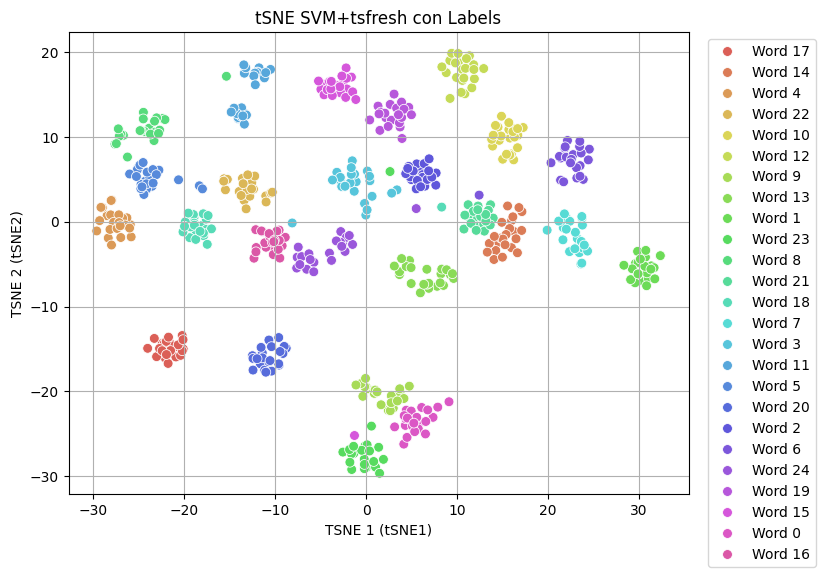

In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler # Transformar los datos a promedio 0 y dev std 1

random_state=42
n_componentes=2

# Estandarizar los datos
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X_full_ts)

# TSNE
tsne = TSNE(n_components=n_componentes,random_state=random_state)
embeddings = tsne.fit_transform(scaled_X)

# Crear un dataframe para las componentes principales
columns = [f'tSNE{i+1}' for i in range(n_componentes)]
principal_df = pd.DataFrame(data=embeddings, columns=columns)
labels = y_full # Añadir la columna de etiquetas (no usada para PCA)

principal_df['LABEL'] = [label_names[label] for label in labels]

# Graficar los puntos en 2D y la matriz rotacion
palette = sns.color_palette("hls", len(label_names)+2)  # or "gist_ncar", "nipy_spectral", etc.
if n_componentes == 2:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=principal_df, x='tSNE1', y='tSNE2', hue=principal_df['LABEL'], palette=palette, s=50, alpha=1)

    plt.title('tSNE SVM+tsfresh con Labels')
    plt.xlabel("TSNE 1 (tSNE1)")
    plt.ylabel("TSNE 2 (tSNE2)")
    plt.legend(bbox_to_anchor=(1.02, 1))
    plt.grid()
    plt.show()

In [30]:
from tsfresh import select_features
from sklearn.feature_selection import SelectKBest, f_classif

X_train_sf = select_features(X_train_ts, y_train_2)
X_test_sf  = X_test_ts[X_train_sf.columns]

# Se selecciona únicamente las N features más importantes debido a exceso de features
N = 460
selector = SelectKBest(score_func=f_classif, k=N)
X_train_np = selector.fit_transform(X_train_sf, y_train_2)
X_test_np = selector.transform(X_test_sf)
selected_features = X_train_sf.columns[selector.get_support()]

X_train_2 = pd.DataFrame(X_train_np, columns=selected_features, index=X_train_sf.index)

X_test_2 = pd.DataFrame(X_test_np, columns=selected_features, index=X_test_sf.index)

print("Modelo Reducido")
print("Train shape:", X_train_2.shape)
print("Test shape:", X_test_2.shape)

Modelo Reducido
Train shape: (460, 460)
Test shape: (115, 460)


In [31]:
from sklearn.model_selection import RepeatedStratifiedKFold #StratifiedKFold para cross-validation
kfold = RepeatedStratifiedKFold(n_splits=4, n_repeats=1, random_state=random_state)

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, mutual_info_classif


# pipeline
pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf'))
])

# Definimos los rangos para C y para Gamma
search_space = {
    'svm__C': Real(1e+1, 1e+10, prior='log-uniform'),
    'svm__gamma': Real(1e-4, 1e+4, prior='log-uniform')
}

search_svm = BayesSearchCV(estimator=pipeline_svm,
                      search_spaces=search_space, scoring='f1_macro',
                      cv=kfold,
                      verbose=4,
                      return_train_score=True,
                      n_jobs=-1) #use all available CPUs

result_svm = search_svm.fit(X_train_2, y_train_2)

print(f'SVM mejor Macro F1 Score en el conj. de validación: {result_svm.best_score_} para {result_svm.best_params_}')

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fi

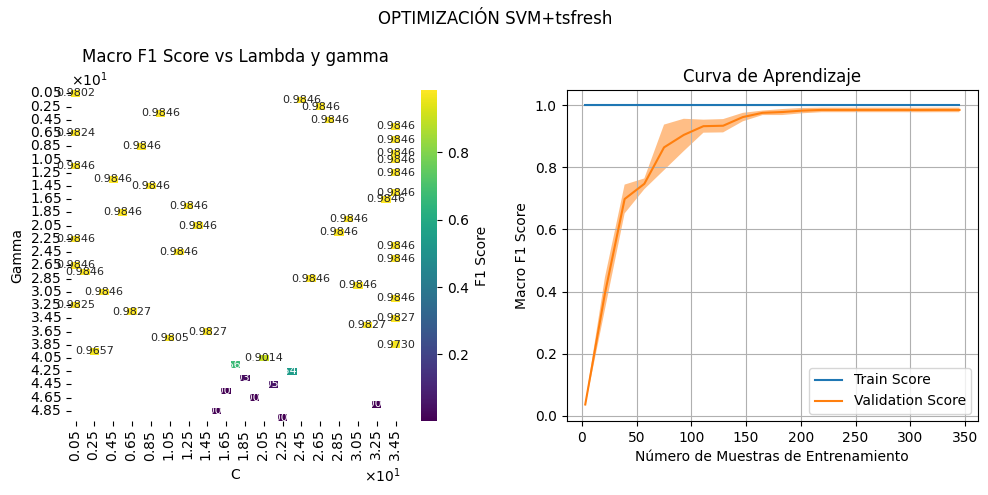

In [32]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import LearningCurveDisplay

# Crea el subplot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
results_svm = search_svm.cv_results_

# Obtener los resultados del search
C_values= results_svm['param_svm__C'].data
Gamma_values= results_svm['param_svm__gamma'].data
mean_test_scores = results_svm['mean_test_score']

# Crear un DataFrame con los resultados
results_df = pd.DataFrame({
    'C': [(C_value) for C_value in C_values], #Se convierte C en Lambda
    'Gamma': [gamma for gamma in Gamma_values], #2 cifras decimales
    'mean_test_score': mean_test_scores
})

# Redondear Lambda y Gamma a 2 decimales para mejorar presentación
results_df['C'] = results_df['C'].round(8)
results_df['Gamma'] = results_df['Gamma'].round(8)

# print(results_df)
# dupes = results_df[results_df.duplicated(subset=["Gamma", "C"], keep=False)]
# print(dupes.sort_values(["Gamma","C"]))

# Pivotar el DataFrame para crear una tabla de resultados
results_df = results_df.pivot(index='Gamma', columns='C', values='mean_test_score')

# Crear el heatmap
sns.heatmap(results_df, annot=True, cmap="viridis", cbar_kws={'label': 'F1 Score'}, annot_kws={"size": 8}, ax=axs[0],fmt=".4f")
axs[0].set_xlabel('C')
axs[0].set_ylabel('Gamma')
axs[0].set_title('Macro F1 Score vs Lambda y gamma')

# Se aplica notación científica en los ejes
axs[0].xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
axs[0].xaxis.get_major_formatter().set_scientific(True)
axs[0].xaxis.get_major_formatter().set_powerlimits((-1, 1))

axs[0].yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
axs[0].yaxis.get_major_formatter().set_scientific(True)
axs[0].yaxis.get_major_formatter().set_powerlimits((-1, 1))


train_sizes=np.linspace(0.01,1.0,20)

# Graficar la curva de Aprendizaje
pipeline_svm.set_params(svm__C=result_svm.best_params_['svm__C'],
                        svm__gamma=result_svm.best_params_['svm__gamma'],
                        svm__probability=True)

LearningCurveDisplay.from_estimator(pipeline_svm,
                                            X=X_train_2,
                                            y=y_train_2,
                                            train_sizes=train_sizes,
                                            cv=kfold,
                                            scoring='f1_macro',
                                            ax=axs[1],
                                            n_jobs=-1)
axs[1].set_title('Curva de Aprendizaje')
axs[1].legend(['Train Score', 'Validation Score'])
axs[1].set_xlabel('Número de Muestras de Entrenamiento')
axs[1].set_ylabel('Macro F1 Score')
axs[1].grid(True)
plt.suptitle("OPTIMIZACIÓN SVM+tsfresh")
plt.tight_layout()
plt.show()

Feature Extraction: 100%|██████████| 518/518 [00:01<00:00, 272.22it/s]
/usr/local/lib/python3.11/dist-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['0__fft_coefficient__attr_"real"__coeff_73'
 '0__fft_coefficient__attr_"real"__coeff_74'
 '0__fft_coefficient__attr_"real"__coeff_75'
 '0__fft_coefficient__attr_"real"__coeff_76'
 '0__fft_coefficient__attr_"real"__coeff_77'
 '0__fft_coefficient__attr_"real"__coeff_78'
 '0__fft_coefficient__attr_"real"__coeff_79'
 '0__fft_coefficient__attr_"real"__coeff_80'
 '0__fft_coefficient__attr_"real"__coeff_81'
 '0__fft_coefficient__attr_"real"__coeff_82'
 '0__fft_coefficient__attr_"real"__coeff_83'
 '0__fft_coefficient__attr_"real"__coeff_84'
 '0__fft_coefficient__attr_"real"__coeff_85'
 '0__fft_coefficient__attr_"real"__coeff_86'
 '0__fft_coefficient__attr_"real"__coeff_87'
 '0__fft_coefficient__attr_"real"__coeff_88'
 '0__fft_coefficient__attr_"real"__coeff_89'
 '0__fft_coefficient__attr_"real"__coeff_90'
 '0__

Tiempo de inferencia SVM+tsfresh: 5.0938215255737305 segundos

Resultados SVM en Test:
acc = 0.9826, macro_f1 = 0.9805, macro_recall = 0.9800, macro_precision = 0.9853


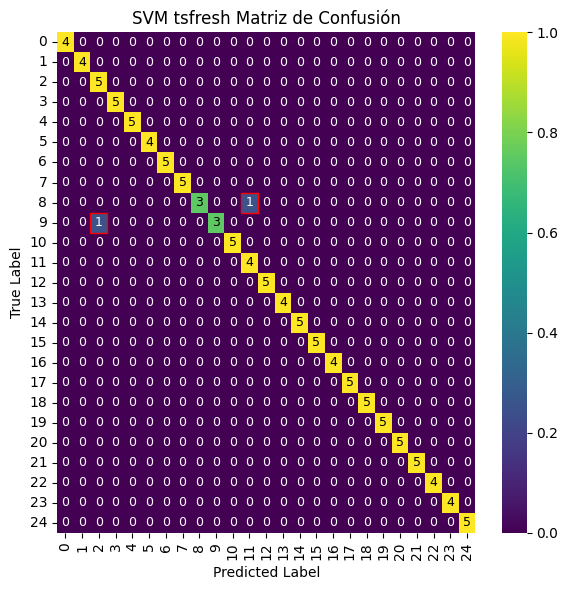

Errores de clasificación: 2/115


In [33]:
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# EVALUACIÓN EN TEST
#reentreno con mejores
pipeline_svm.set_params(svm__C=result_svm.best_params_['svm__C'],
                        svm__gamma=result_svm.best_params_['svm__gamma'],
                        svm__probability=True)
pipeline_svm.fit(X_train_2, y_train_2)

#Evaluamos en el conjunto de test
# Preprocesamiento de datos para el modelo SVM+tsfresh
inicio=time.time()
X_test_ts  = tsfresh_extract_features(df_test,  column_id="id", column_sort="time", column_kind="kind", column_value="value")
X_test_ts  = impute(X_test_ts)
X_test_ts  = X_test_ts[X_train_ts.columns].dropna(axis=1, how="all")
X_test_sf  = X_test_ts[X_train_sf.columns]
X_test_np = selector.transform(X_test_sf)
X_test_2 = pd.DataFrame(X_test_np, columns=selected_features, index=X_test_sf.index)
pred_test_svm = pipeline_svm.predict(X_test_2)
fin=time.time()
print("Tiempo de inferencia SVM+tsfresh:", (fin-inicio), "segundos")

macro_f1 = metrics.f1_score(y_test, pred_test_svm, average='macro')
acc = metrics.accuracy_score(y_test, pred_test_svm)
macro_recall = metrics.recall_score(y_test, pred_test_svm, average='macro')
macro_precision = metrics.precision_score(y_test, pred_test_svm, average='macro')

print(f"\nResultados SVM en Test:")
print(f"acc = {acc:.4f}, macro_f1 = {macro_f1:.4f}, macro_recall = {macro_recall:.4f}, macro_precision = {macro_precision:.4f}")

cm = confusion_matrix(y_test, pred_test_svm)
cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]
cm_normalized = np.nan_to_num(cm_normalized)  # replace NaN with 0

fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm_normalized, xticklabels=all_categories, yticklabels=all_categories,
    cmap="viridis", cbar=True, annot=False,ax=ax)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title(f"SVM tsfresh Matriz de Confusión")
# Annotate with counts
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        text_color = "white" if cm_normalized[i, j] < 0.5 else "black"
        ax.text(j + 0.5, i + 0.5, str(count),
                ha="center", va="center", color=text_color, fontsize=9)

# Highlight errors with red rectangles
errores = 0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if i != j and cm[i, j] > 0:
            ax.add_patch(
                plt.Rectangle((j, i), 1, 1,
                              fill=False, edgecolor='red', linewidth=1)
            )
            errores += cm[i, j]

plt.tight_layout()
plt.show()
print(f"Errores de clasificación: {errores}/{len(y_test)}")

## MODELOS PROFUNDOS

### Definición de Modelos (RNN, LSTM, GRU, BiLSTM y TCN) como LightningModule

In [34]:
from pytorch_tcn import TCN

In [35]:
class Lightning_RNN(pl.LightningModule):
    def __init__(self, input_dim, hidden_dim, num_classes, lr, rnn_type="RNN", num_layers=1, class_weights=None):
        super().__init__()

        if rnn_type == "RNN":
            self.model = torch.nn.RNN(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        elif rnn_type == "LSTM":
            self.model = torch.nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        elif rnn_type == "GRU":
            self.model = torch.nn.GRU(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        elif rnn_type == "BiLSTM":
            self.model = torch.nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        elif rnn_type == "TCN":
            self.model = TCN(num_inputs=input_dim, num_channels=[hidden_dim] * num_layers, kernel_size=3, dropout=0.2)
        else:
            raise ValueError(f"Unknown rnn_type: {rnn_type}")
        self.rnn_type=rnn_type
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.learning_rate = lr
        self.classes = num_classes
        self.register_buffer("class_weights", class_weights) #Se utiliza para asegurarse que los class_weight estén en el mismo device que el modelo "auto"

        # Guardar hiperparametros en directorio de logs
        # Ignora los pesos del modelo
        self.save_hyperparameters(ignore=["model"])

        # Definición de métricas para cada grupo de datos
        self.train_acc = torchmetrics.Accuracy(num_classes = self.classes, task='multiclass')
        self.valid_acc = torchmetrics.Accuracy(num_classes = self.classes, task='multiclass')
        self.test_acc = torchmetrics.Accuracy(num_classes = self.classes, task='multiclass')
        self.train_f1 = torchmetrics.F1Score(num_classes = self.classes, task='multiclass', average='macro')
        self.valid_f1 = torchmetrics.F1Score(num_classes = self.classes, task='multiclass', average='macro')
        self.test_f1 = torchmetrics.F1Score(num_classes = self.classes, task='multiclass', average='macro')

    def forward(self, x, lengths=None):
      if self.rnn_type in ["RNN", "GRU", "LSTM", "BiLSTM"]:
            # Se desempaqueta los valores utilizando la longitud original previo al padding
            if lengths is not None:
                packed = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
                output, hidden = self.model(packed)
                output, _ = nn.utils.rnn.pad_packed_sequence(output, batch_first=True)
            else:
                output, hidden = self.model(x)

            # En caso de LSTM se asigna a hidden solo como h y no como el estado C
            if isinstance(hidden, tuple):
                hidden = hidden[0]

            last_hidden = hidden[-1]  # Se elige únicamente la última secuencia de hidden (Many to One) No se elige hacer el promedio como se hizo con la CRNN
            out = self.fc(last_hidden)  # Se añade una capa final para el clasificador
      else:
            x = self.model(x.transpose(1, 2))  # input must be (batch, channels, seq_len)
            x = x.transpose(1, 2)            # back to (batch, seq_len, hidden_dim)
            last_hidden = x[:, -1, :]             # last timestep (batch, hidden_dim)

      out = self.fc(last_hidden)  # Se añade una capa final para el clasificador
      return out

    # Pasos del proceso forward comunes entre train, val, test
    def _shared_step(self, batch):
        features, true_labels, lengths= batch
        logits = self(features, lengths)
        if self.class_weights==None:
          loss = torch.nn.functional.cross_entropy(logits, true_labels)
        else:
          loss = torch.nn.functional.cross_entropy(logits, true_labels, weight=self.class_weights)
           # cross entropy loss recibe logits y labels como entrada. No recibe probabilidades!
        predicted_labels = torch.argmax(logits, dim=1)

        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.log("train_loss", loss)
        self.train_acc(predicted_labels, true_labels)
        self.log("train_acc", self.train_acc, on_epoch=True, on_step=False)
        self.train_f1(predicted_labels, true_labels)
        self.log("train_f1", self.train_f1, on_epoch=True, on_step=False)
        self.model.train()

        return loss

    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.log("valid_loss", loss)
        self.valid_acc(predicted_labels, true_labels)
        self.log("valid_acc", self.valid_acc, on_epoch=True, on_step=False, prog_bar=True)
        self.valid_f1(predicted_labels, true_labels)
        self.log("valid_f1", self.valid_f1, on_epoch=True, on_step=False, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.test_acc(predicted_labels, true_labels)
        self.log("test_acc", self.test_acc, on_epoch=True, on_step=False)
        self.test_f1(predicted_labels, true_labels)
        self.log("test_f1", self.test_f1, on_epoch=True, on_step=False)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr = self.learning_rate)
        return optimizer

### ENTRENAMIENTO DE MODELOS PROFUNDOS


#### FUNCIONES GENERALES PARA ENTRENAMIENTO Y EVALUACIÓN

In [36]:
def train_model(model_class, data_module, model_name, input_dim, hidden_dim, num_classes,
                lr, num_layers, class_weights, num_epochs, patience):

    # Callbacks & logger
    callback_check = ModelCheckpoint(save_top_k=1,mode="max",monitor="valid_f1",filename=f"{model_name}-best")
    callback_tqdm = RichProgressBar(leave=False)
    logger = CSVLogger(save_dir="logs/", name=model_name)

    early_stop_callback = EarlyStopping(monitor="valid_f1",mode="max", patience=patience)

    # Model initialization
    lightning_model = model_class(input_dim=input_dim, hidden_dim=hidden_dim, num_classes=num_classes,
                                  rnn_type=model_name, lr=lr, num_layers=num_layers, class_weights=class_weights)

    # Trainer setup
    trainer = pl.Trainer(max_epochs=num_epochs, callbacks=[callback_check, callback_tqdm, early_stop_callback],
                         accelerator="auto", devices="auto", logger=logger, deterministic=False, log_every_n_steps=10)

    # Training
    start_time = time.time()
    trainer.fit(model=lightning_model, datamodule=data_module)
    runtime = (time.time() - start_time) / 60
    print(f"Tiempo de entrenamiento de {model_name} en minutos: {runtime:.2f}")

    return lightning_model, trainer

In [37]:
def plot_metrics(trainer, title_name='Métricas Modelo'):
    # Load metrics
    metrics_model = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

    # Aggregate by epoch (average over steps if needed)
    aggreg_metrics = []
    agg_col = "epoch"
    for i, dfg in metrics_model.groupby(agg_col):
        agg = dict(dfg.mean())
        agg[agg_col] = i
        aggreg_metrics.append(agg)

    df_metrics = pd.DataFrame(aggreg_metrics)

    # Create 1x3 subplot grid
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Loss
    df_metrics[["train_loss", "valid_loss"]].plot(
        ax=axes[0], grid=True, legend=True, xlabel="Epoch", ylabel="Loss", title="Curva Loss"
    )

    # # Accuracy
    # df_metrics[["train_acc", "valid_acc"]].plot(
    #     ax=axes[1], grid=True, legend=True, xlabel="Epoch", ylabel="Accuracy", title="Curva Accuracy"
    # )

    # F1 Score
    df_metrics[["train_f1", "valid_f1"]].plot(
        ax=axes[1], grid=True, legend=True, xlabel="Epoch", ylabel="F1 Score (macro)", title="Curva F1 Score"
    )
    plt.suptitle(title_name, fontweight='bold', fontsize=16)
    plt.tight_layout()
    plt.show()

In [38]:
def evaluate_model(lightning_model, data_module, all_categories, model_name=''):
    y_true, y_pred = [], []

    # Forward pass over test data
    lightning_model.eval()
    with torch.no_grad():
        for features, labels, lengths in data_module.test_dataloader():
            outputs = lightning_model(features, lengths)
            preds = torch.argmax(outputs, dim=1)

            y_true.extend(labels.tolist())
            y_pred.extend(preds.tolist())

    # Compute metrics
    macro_f1 = metrics.f1_score(y_true, y_pred, average='macro')
    acc = metrics.accuracy_score(y_true, y_pred)
    macro_recall = metrics.recall_score(y_true, y_pred, average='macro')
    macro_precision = metrics.precision_score(y_true, y_pred, average='macro')

    print(f"\nResultados {model_name} en Test:")
    print(f"acc = {acc:.4f}, macro_f1 = {macro_f1:.4f}, "
          f"macro_recall = {macro_recall:.4f}, macro_precision = {macro_precision:.4f}\n")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.nan_to_num(cm_normalized)  # replace NaN with 0

    fig, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(cm_normalized, xticklabels=all_categories, yticklabels=all_categories,
        cmap="viridis", cbar=True, annot=False,ax=ax)

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.title(f"{model_name} Matriz de Confusión")
    # Annotate with counts
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count = cm[i, j]
            text_color = "white" if cm_normalized[i, j] < 0.5 else "black"
            ax.text(j + 0.5, i + 0.5, str(count),
                    ha="center", va="center", color=text_color, fontsize=9)

    # Highlight errors with red rectangles
    errores = 0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if i != j and cm[i, j] > 0:
                ax.add_patch(
                    plt.Rectangle((j, i), 1, 1,
                                  fill=False, edgecolor='red', linewidth=1)
                )
                errores += cm[i, j]

    plt.tight_layout()
    plt.show()
    print(f"Errores de clasificación: {errores}/{len(y_true)}")

#### ENTRENAMIENTO DE MODELOS

In [49]:
lightning_model={}
trainer={}
model_names=['RNN', 'LSTM','GRU','BiLSTM', 'TCN']

In [50]:
for model_name in model_names:
    lightning_model[model_name], trainer[model_name]=train_model(Lightning_RNN, data_module, model_name, input_dim=n_dimensions,
                                                                         hidden_dim=HIDDEN_DIM, num_classes=n_categories, lr=LEARNING_RATE,
                                                                         num_layers=NUM_LAYERS,class_weights=class_weights,
                                                                         num_epochs=NUM_EPOCHS, patience=PATIENCE)

INFO:pytorch_lightning.utilities.rank_zero:Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type               ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ RNN                │  277 K │ train │
│ 1 │ fc        │ Linear             │  4.0 K │ train │
│ 2 │ train_acc │ MulticlassAccuracy │      0 │ train │
│ 3 │ valid_acc │ MulticlassAccuracy │      0 │ train │
│ 4 │ test_acc  │ MulticlassAccuracy │      0 │ train │
│ 5 │ train_f1  │ MulticlassF1Score  │      0 │ train │
│ 6 │ valid_f1  │ MulticlassF1Score  │      0 │ train │
│ 7 │ test_f1   │ MulticlassF1Score  │      0 │ train │
└───┴───────────┴────────────────────┴────────┴───────┘

Trainable params: 281 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 281 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 8                                                                                           
Modules in eval mode: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Tiempo de entrenamiento de RNN en minutos: 1.96


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type               ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ LSTM               │  1.1 M │ train │
│ 1 │ fc        │ Linear             │  4.0 K │ train │
│ 2 │ train_acc │ MulticlassAccuracy │      0 │ train │
│ 3 │ valid_acc │ MulticlassAccuracy │      0 │ train │
│ 4 │ test_acc  │ MulticlassAccuracy │      0 │ train │
│ 5 │ train_f1  │ MulticlassF1Score  │      0 │ train │
│ 6 │ valid_f1  │ MulticlassF1Score  │      0 │ train │
│ 7 │ test_f1   │ MulticlassF1Score  │      0 │ train │
└───┴───────────┴────────────────────┴────────┴───────┘

Trainable params: 1.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.1 M                                                                                                
Total estimated model params size (MB): 4                                                                          
Modules in train mode: 8                                                                                           
Modules in eval mode: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Tiempo de entrenamiento de LSTM en minutos: 1.85


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type               ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ GRU                │  833 K │ train │
│ 1 │ fc        │ Linear             │  4.0 K │ train │
│ 2 │ train_acc │ MulticlassAccuracy │      0 │ train │
│ 3 │ valid_acc │ MulticlassAccuracy │      0 │ train │
│ 4 │ test_acc  │ MulticlassAccuracy │      0 │ train │
│ 5 │ train_f1  │ MulticlassF1Score  │      0 │ train │
│ 6 │ valid_f1  │ MulticlassF1Score  │      0 │ train │
│ 7 │ test_f1   │ MulticlassF1Score  │      0 │ train │
└───┴───────────┴────────────────────┴────────┴───────┘

Trainable params: 837 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 837 K                                                                                                
Total estimated model params size (MB): 3                                                                          
Modules in train mode: 8                                                                                           
Modules in eval mode: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Tiempo de entrenamiento de GRU en minutos: 1.48


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type               ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ LSTM               │  3.2 M │ train │
│ 1 │ fc        │ Linear             │  4.0 K │ train │
│ 2 │ train_acc │ MulticlassAccuracy │      0 │ train │
│ 3 │ valid_acc │ MulticlassAccuracy │      0 │ train │
│ 4 │ test_acc  │ MulticlassAccuracy │      0 │ train │
│ 5 │ train_f1  │ MulticlassF1Score  │      0 │ train │
│ 6 │ valid_f1  │ MulticlassF1Score  │      0 │ train │
│ 7 │ test_f1   │ MulticlassF1Score  │      0 │ train │
└───┴───────────┴────────────────────┴────────┴───────┘

Trainable params: 3.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.2 M                                                                                                
Total estimated model params size (MB): 12                                                                         
Modules in train mode: 8                                                                                           
Modules in eval mode: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Tiempo de entrenamiento de BiLSTM en minutos: 2.07


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type               ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ TCN                │  833 K │ train │
│ 1 │ fc        │ Linear             │  4.0 K │ train │
│ 2 │ train_acc │ MulticlassAccuracy │      0 │ train │
│ 3 │ valid_acc │ MulticlassAccuracy │      0 │ train │
│ 4 │ test_acc  │ MulticlassAccuracy │      0 │ train │
│ 5 │ train_f1  │ MulticlassF1Score  │      0 │ train │
│ 6 │ valid_f1  │ MulticlassF1Score  │      0 │ train │
│ 7 │ test_f1   │ MulticlassF1Score  │      0 │ train │
└───┴───────────┴────────────────────┴────────┴───────┘

Trainable params: 837 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 837 K                                                                                                
Total estimated model params size (MB): 3                                                                          
Modules in train mode: 118                                                                                         
Modules in eval mode: 0

Output()

Tiempo de entrenamiento de TCN en minutos: 0.46


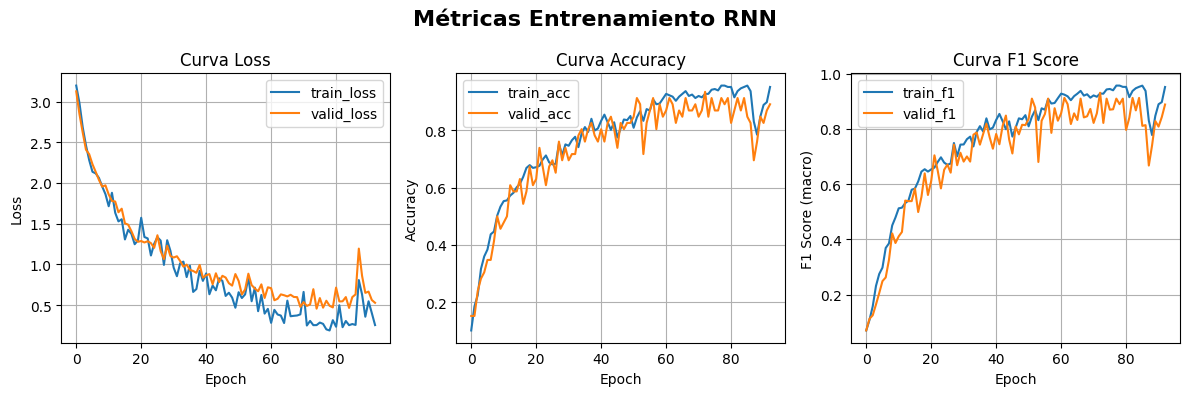

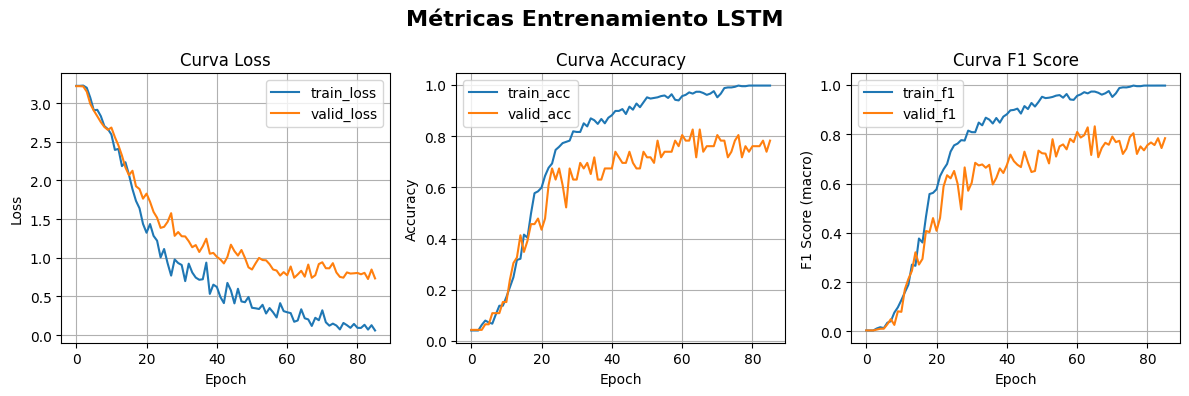

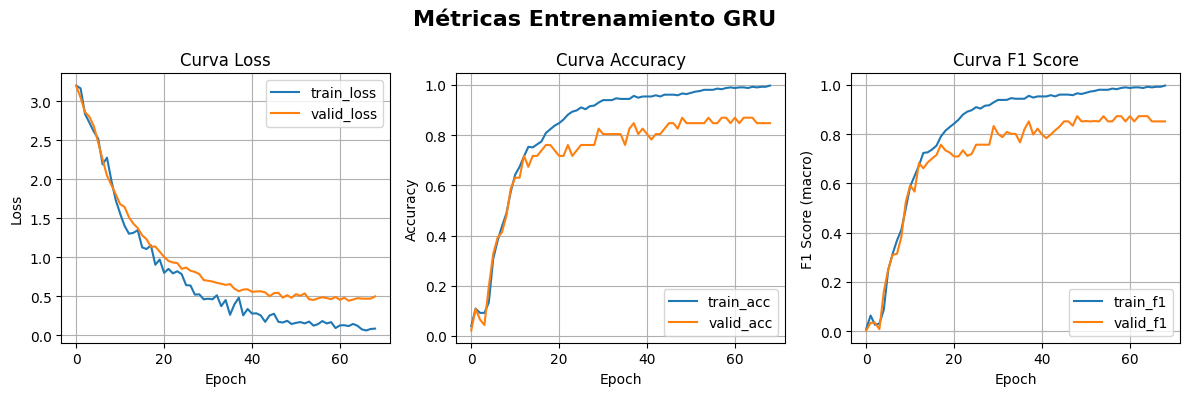

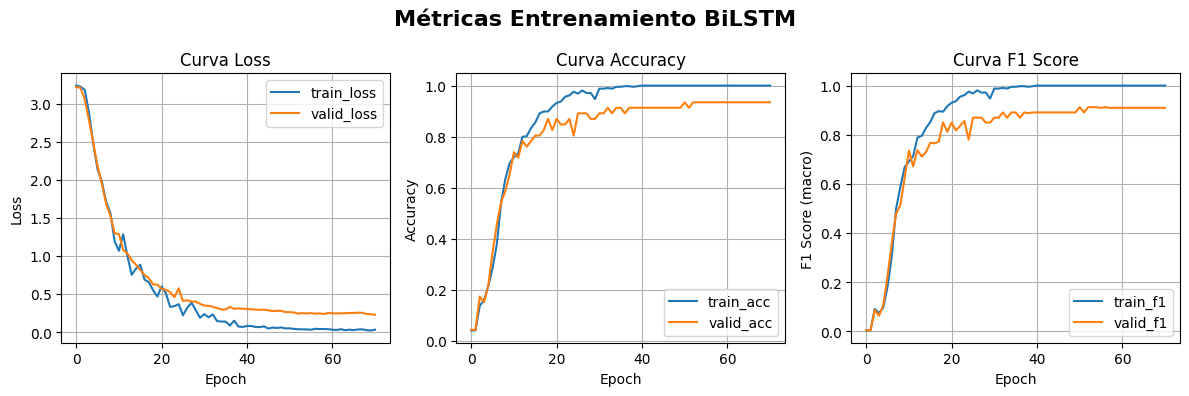

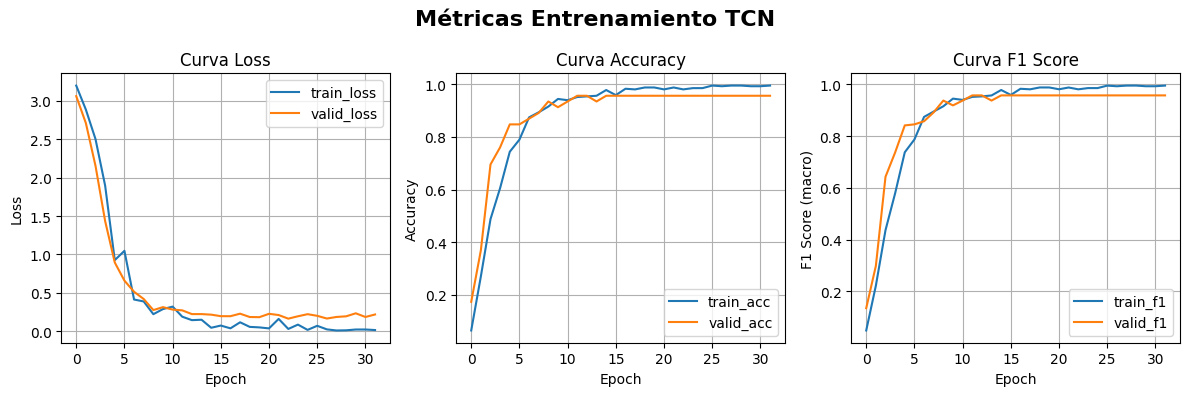

In [51]:
for model_name in model_names:
  plot_metrics(trainer[model_name], f'Métricas Entrenamiento {model_name}')

#### EVALUACIÓN DE MODELOS

In [52]:
for model_name in model_names:
  print(f'\nDesempeño Modelo {model_name}')
  inicio=time.time()
  trainer[model_name].test(model = lightning_model[model_name], datamodule = data_module, ckpt_path = 'best')
  fin=time.time()
  print("Tiempo promedio:", model_name, tiempo, "segundos")

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at logs/RNN/version_28/checkpoints/RNN-best.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at logs/RNN/version_28/checkpoints/RNN-best.ckpt



Desempeño Modelo RNN


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.800000011920929     │
│          test_f1          │    0.7848802804946899     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at logs/LSTM/version_12/checkpoints/LSTM-best.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at logs/LSTM/version_12/checkpoints/LSTM-best.ckpt


Tiempo promedio: RNN 43.42968847299926 segundos

Desempeño Modelo LSTM


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8608695864677429     │
│          test_f1          │    0.8596594333648682     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at logs/GRU/version_11/checkpoints/GRU-best.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at logs/GRU/version_11/checkpoints/GRU-best.ckpt


Tiempo promedio: LSTM 43.42968847299926 segundos

Desempeño Modelo GRU


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.886956512928009     │
│          test_f1          │    0.8824560642242432     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at logs/BiLSTM/version_10/checkpoints/BiLSTM-best.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at logs/BiLSTM/version_10/checkpoints/BiLSTM-best.ckpt


Tiempo promedio: GRU 43.42968847299926 segundos

Desempeño Modelo BiLSTM


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.947826087474823     │
│          test_f1          │    0.9444876909255981     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at logs/TCN/version_28/checkpoints/TCN-best.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at logs/TCN/version_28/checkpoints/TCN-best.ckpt


Tiempo promedio: BiLSTM 43.42968847299926 segundos

Desempeño Modelo TCN


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.991304337978363     │
│          test_f1          │    0.9898412227630615     │
└───────────────────────────┴───────────────────────────┘

Tiempo promedio: TCN 43.42968847299926 segundos



Resultados RNN en Test:
acc = 0.8000, macro_f1 = 0.7849, macro_recall = 0.7920, macro_precision = 0.8191



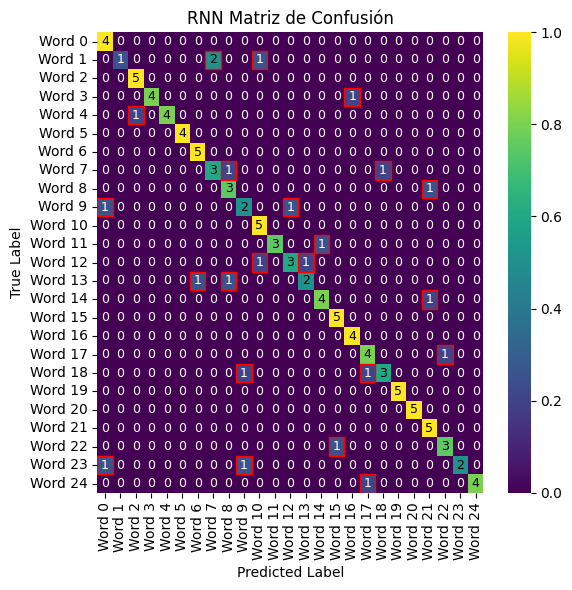

Errores de clasificación: 23/115

Resultados LSTM en Test:
acc = 0.8609, macro_f1 = 0.8597, macro_recall = 0.8620, macro_precision = 0.8841



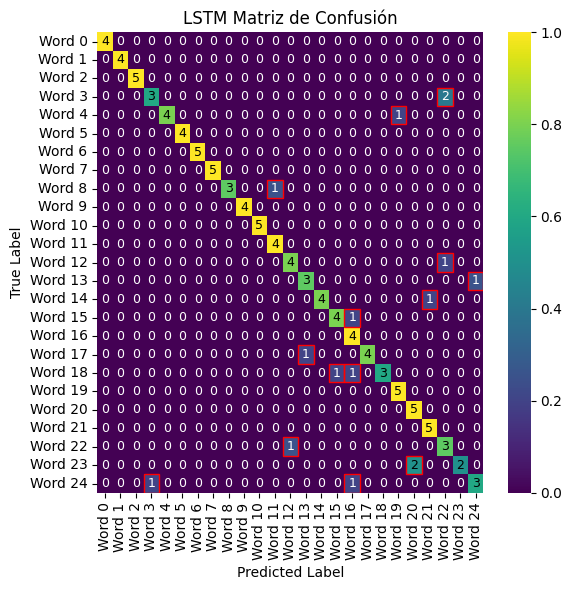

Errores de clasificación: 16/115

Resultados GRU en Test:
acc = 0.8870, macro_f1 = 0.8825, macro_recall = 0.8860, macro_precision = 0.8999



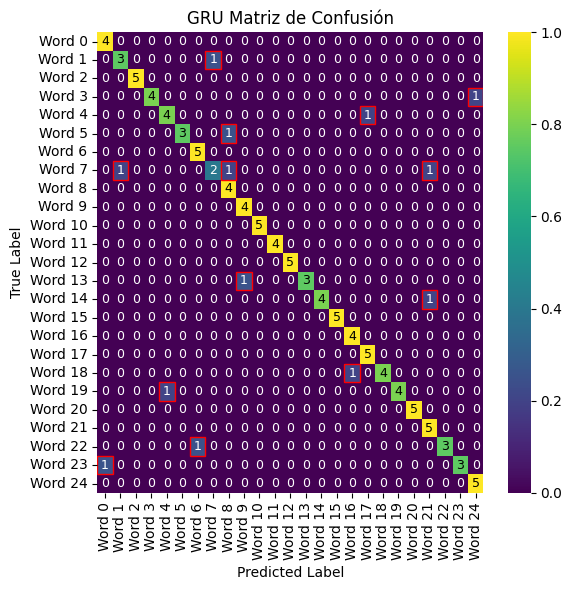

Errores de clasificación: 13/115

Resultados BiLSTM en Test:
acc = 0.9478, macro_f1 = 0.9445, macro_recall = 0.9460, macro_precision = 0.9520



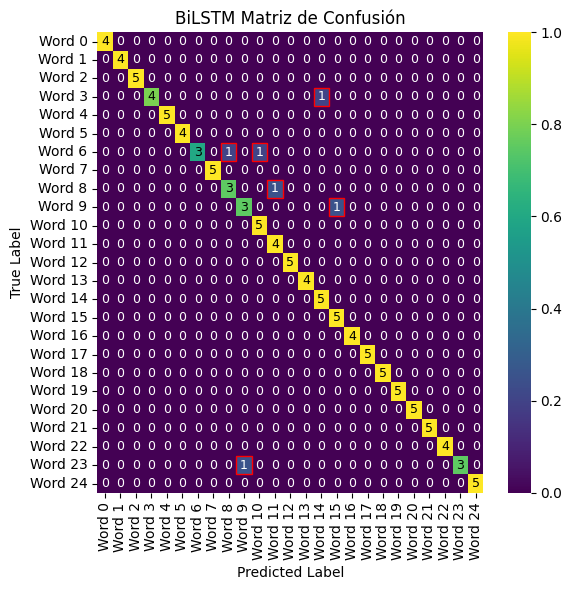

Errores de clasificación: 6/115

Resultados TCN en Test:
acc = 0.9913, macro_f1 = 0.9898, macro_recall = 0.9900, macro_precision = 0.9920



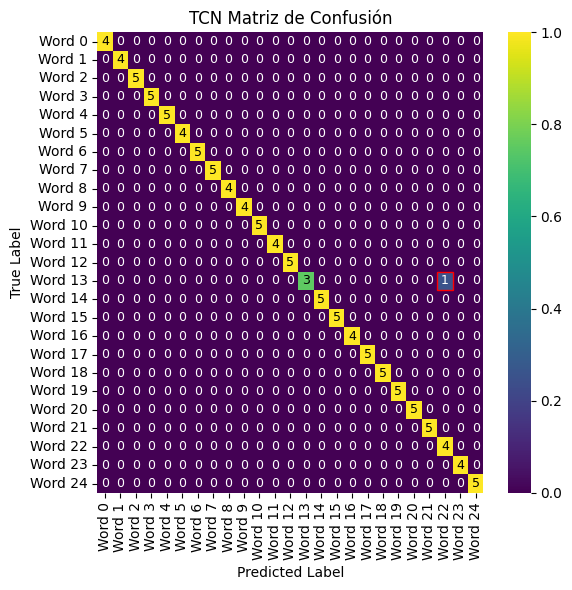

Errores de clasificación: 1/115


In [53]:
labels=[label_names[i] for i in sorted(label_names.keys())]
for model_name in model_names:
  evaluate_model(lightning_model[model_name], data_module, labels, model_name)